# Exploring Autoencoders: Variants and Applications

Sharat KN 

#### Use the CIFAR10 dataset provided in Keras, after conversion to gray-level images!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from keras.datasets import cifar10
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert to grayscale
x_train_gray = np.dot(x_train[...,:3], [0.2989, 0.5870, 0.1140])
x_test_gray = np.dot(x_test[...,:3], [0.2989, 0.5870, 0.1140])

# Normalize the images
x_train_gray = x_train_gray / 255.0
x_test_gray = x_test_gray / 255.0

# Flatten the images
x_train_flat = x_train_gray.reshape(x_train_gray.shape[0], -1)
x_test_flat = x_test_gray.reshape(x_test_gray.shape[0], -1)

In [3]:
# Standardize the data
scaler = StandardScaler()
x_train_flat = scaler.fit_transform(x_train_flat)
x_test_flat = scaler.transform(x_test_flat)

## Task 1
#### Perform standard PCA and identify the eigenvectors associated with top eigenvalues with 95% total energy (i,e.,  >=95 percent). Using these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.

In [4]:
# Perform PCA
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

In [5]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(x_train_pca, y_train.ravel())

LogisticRegression(max_iter=10000)

In [6]:
# Predict probabilities
y_score = log_reg.predict_proba(x_test_pca)

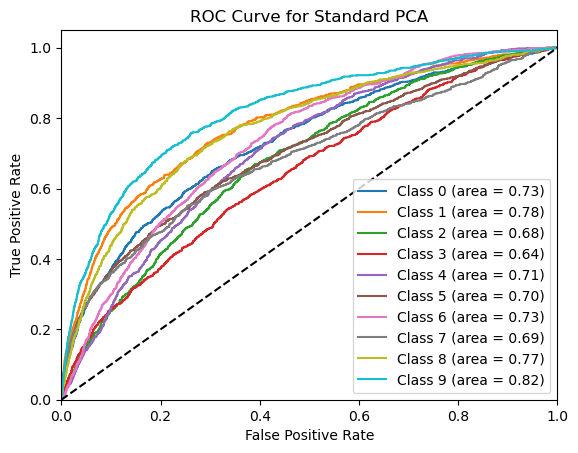

In [7]:
# Draw ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Standard PCA')
plt.legend(loc="lower right")
plt.show()

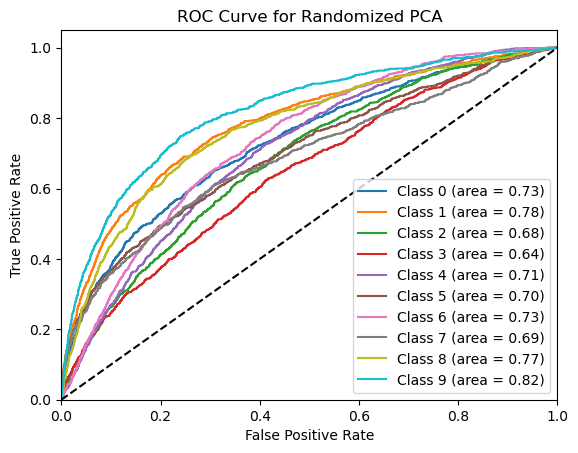

In [8]:
# Perform Randomized PCA
rpca = PCA(n_components=100, svd_solver='randomized')
x_train_rpca = rpca.fit_transform(x_train_flat)
x_test_rpca = rpca.transform(x_test_flat)

# Train Logistic Regression
log_reg_rpca = LogisticRegression(max_iter=10000)
log_reg_rpca.fit(x_train_rpca, y_train.ravel())

# Predict probabilities
y_score_rpca = log_reg_rpca.predict_proba(x_test_rpca)

# Draw ROC Curve
fpr_rpca = {}
tpr_rpca = {}
roc_auc_rpca = {}

for i in range(10):
    fpr_rpca[i], tpr_rpca[i], _ = roc_curve(y_test == i, y_score_rpca[:, i])
    roc_auc_rpca[i] = auc(fpr_rpca[i], tpr_rpca[i])

# Plot ROC curve for Randomized PCA
plt.figure()
for i in range(10):
    plt.plot(fpr_rpca[i], tpr_rpca[i], label=f'Class {i} (area = {roc_auc_rpca[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Randomized PCA')
plt.legend(loc="lower right")
plt.show()

Both Randomized PCA and Standard PCA show similar performance across most classes, with the ROC curves being quite close to each other. We observe that both models are consistent in their performance for image classification tasks in this context. Neither method shows a significant advantage over the other.

## Task 2
#### Train a single layer autoencoder with linear activation function and appropriate normalization of the input.

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [10]:
# Normalize and flatten data
scaler = StandardScaler()
x_train_flat_normalized = scaler.fit_transform(x_train_flat)
x_test_flat_normalized = scaler.transform(x_test_flat)

In [11]:
# Set the number of components
n_components = pca.n_components_  # Use the number of components retained by PCA

In [12]:
# Define the autoencoder model
input_img = Input(shape=(x_train_flat_normalized.shape[1],))
encoded = Dense(n_components, activation='linear')(input_img)
decoded = Dense(x_train_flat_normalized.shape[1], activation='linear')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

# Compile the model
autoencoder.compile(optimizer=Adam(), loss='mse')

In [13]:
autoencoder.summary(0)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 163)            │       167,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       167,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,011 (1.28 MB)

 Trainable params: 335,011 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the autoencoder
autoencoder.fit(x_train_flat_normalized, x_train_flat_normalized,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat_normalized, x_test_flat_normalized))

# Extract the weights (eigenvectors)
autoencoder_weights = encoder.layers[1].get_weights()[0]

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4767 - val_loss: 0.1280
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1121 - val_loss: 0.0836
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0781 - val_loss: 0.0674
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0647 - val_loss: 0.0601
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0584 - val_loss: 0.0569
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0557 - val_loss: 0.0547
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0543 - val_loss: 0.0538
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0533 - val_loss: 0.0533
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0529 - val_loss: 0.0540
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0533 - val_loss: 0.0528
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0524 - val_loss: 0.0523
Epoch 12/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

In [15]:
# Calculate the reconstruction error
reconstructed_imgs = autoencoder.predict(x_test_flat_normalized)
mse_single_layer = np.mean(np.square(x_test_flat_normalized - reconstructed_imgs))
print("Reconstruction Error (Single-Layer Autoencoder):", mse_single_layer)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction Error (Single-Layer Autoencoder): 0.051742014030622896


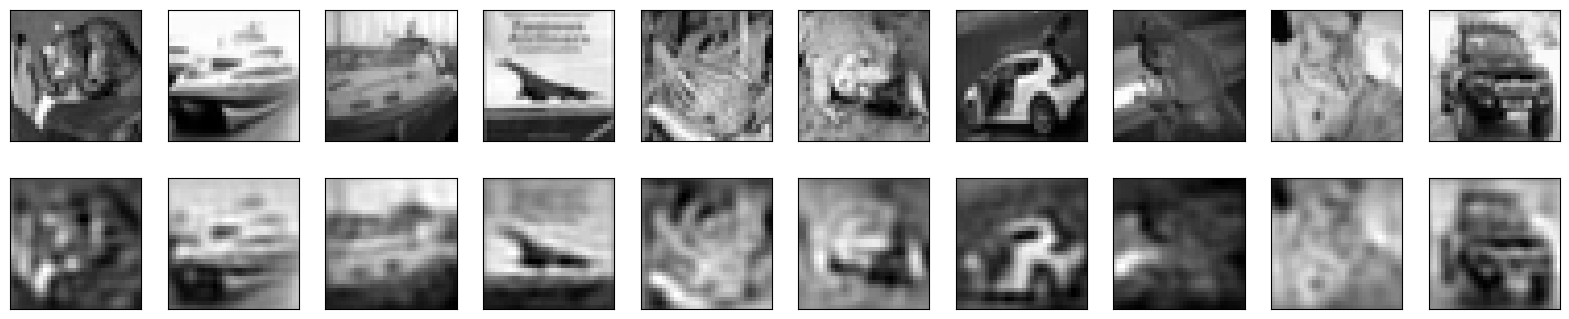

In [16]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

# Plot original and reconstructed images
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#### Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders.

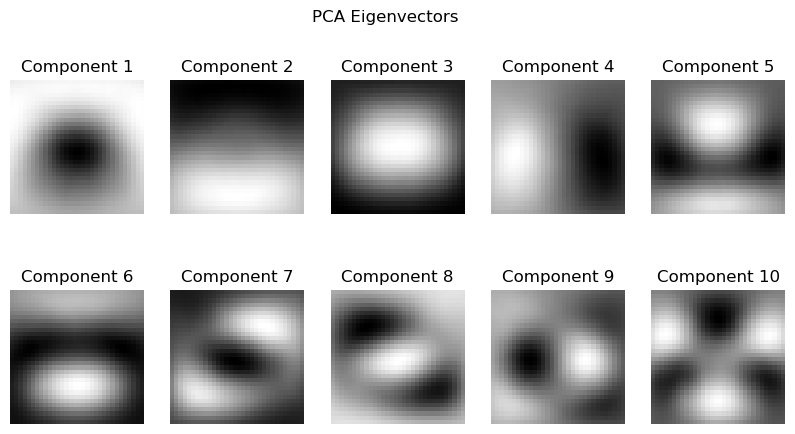

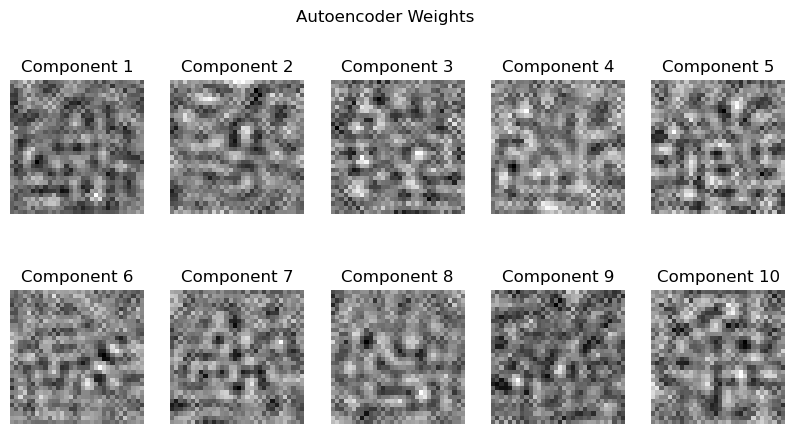

In [17]:
import matplotlib.pyplot as plt

# Function to visualize eigenvectors/weights
def plot_vectors(vectors, title, num_vectors=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_vectors):
        plt.subplot(2, 5, i + 1)
        plt.imshow(vectors[:, i].reshape(32, 32), cmap='gray')
        plt.title(f'Component {i+1}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Eigenvectors from PCA
pca_components = pca.components_

# Plot PCA eigenvectors
plot_vectors(pca_components.T, 'PCA Eigenvectors')

# Plot Autoencoder weights
plot_vectors(autoencoder_weights, 'Autoencoder Weights')

The PCA eigenvectors (components) are generally smooth and display global patterns across the image. Each component highlights different features, such as edges and gradients. These features are interpretable as they reflect variations in image intensity and structure. The components primarily capture low-frequency information, which means that they represent general trends rather than fine details.

The weights learned by the autoencoder appear to be more noisy and high-frequency compared to the PCA eigenvectors. This suggests that the autoencoder captures more localized and detailed features of the images.  The autoencoder weights are less interpretable and more complex. The autoencoder seems to focus on more localized patterns, potentially capturing specific textures or small features within the images.

While PCA provides a clear and interpretable set of global features, the autoencoder offers a richer, albeit more complex, set of features that include both global patterns and fine details.

## TASK 3 - Part 1
#### Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error and compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset

In [18]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

# Reshape data for convolutional layers
x_train_reshaped = x_train_gray[..., np.newaxis]
x_test_reshaped = x_test_gray[..., np.newaxis]

# Define the deep convolutional autoencoder
input_img = Input(shape=(32, 32, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(n_components, activation='linear')(x)

# Decoder
x = Dense(8 * 8 * 64, activation='relu')(encoded)
x = Reshape((8, 8, 64))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

deepautoencoder = Model(input_img, decoded)
deepencoder = Model(input_img, encoded)

# Compile the model
deepautoencoder.compile(optimizer=Adam(), loss='mse')

deepautoencoder.summary(0)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 163)            │       667,811 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │       671,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,377,124 (5.25 MB)

 Trainable params: 1,377,124 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the autoencoder
deepautoencoder.fit(x_train_reshaped, x_train_reshaped,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_reshaped, x_test_reshaped))

# Calculate the reconstruction error
reconstructed_imgs_cae = deepautoencoder.predict(x_test_reshaped)
mse_deep_cae = np.mean(np.square(x_test_reshaped - reconstructed_imgs_cae))
print("Reconstruction Error (Deep Convolutional Autoencoder):", mse_deep_cae)

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - loss: 0.0290 - val_loss: 0.0095
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - loss: 0.0088 - val_loss: 0.0070
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 124ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 126ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 12/20
196/196

Reconstruction Error (Single-Layer Autoencoder): 0.0517

Reconstruction Error (Deep Convolutional Autoencoder): 0.00345

The Single-Layer Autoencoder has fewer parameters and is simpler, and does not capture complex patterns as effectively as a deep model. Hence a comparatively high reconstruction error.
Deep Convolutional Autoencoder is more complex and captures intricate spatial features due to convolutional layers, which results in a lower reconstruction error.

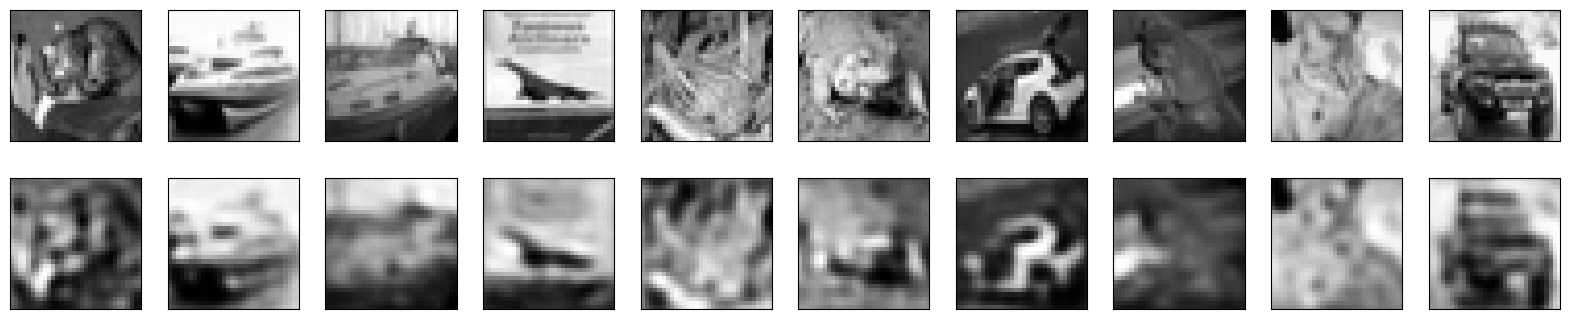

In [20]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

# Plot original and reconstructed images
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs_cae[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Task 3 - Part 2
#### What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer.

In [21]:
hidden_nodes = n_components // 3

input_img = Input(shape=(x_train_flat_normalized.shape[1],))
# Encoder
encoded = Dense(hidden_nodes, activation='sigmoid')(input_img)
encoded = Dense(hidden_nodes, activation='sigmoid')(encoded)
encoded = Dense(hidden_nodes, activation='sigmoid')(encoded)

# Decoder
decoded = Dense(hidden_nodes, activation='sigmoid')(encoded)
decoded = Dense(hidden_nodes, activation='sigmoid')(decoded)
decoded = Dense(x_train_flat_normalized.shape[1], activation='linear')(decoded)

autoencoder_1 = Model(input_img, decoded)
encoder_1 = Model(input_img, encoded)

# Compile the model
autoencoder_1.compile(optimizer=Adam(), loss='mse')

autoencoder_1.summary(0)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 54)             │        55,350 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 54)             │         2,970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │        56,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,550 (482.62 KB)

 Trainable params: 123,550 (482.62 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train the autoencoder
autoencoder_1.fit(x_train_flat_normalized, x_train_flat_normalized,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_flat_normalized, x_test_flat_normalized))


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9558 - val_loss: 0.7434
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7309 - val_loss: 0.6385
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6303 - val_loss: 0.6235
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6138 - val_loss: 0.6103
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.6060 - val_loss: 0.6041
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5985 - val_loss: 0.6015
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5936 - val_loss: 0.5996
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5973 - val_loss: 0.5991
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5936 - val_loss: 0.5990
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5958 - val_loss: 0.5980
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5925 - val_loss: 0.5984
Epoch 12/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [23]:
# Calculate the reconstruction error
reconstructed_imgs_1 = autoencoder_1.predict(x_test_flat_normalized)
mse_three_layer = np.mean(np.square(x_test_flat_normalized - reconstructed_imgs_1))
print("Reconstruction Error (3 Hidden Layer Autoencoder):", mse_three_layer)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction Error (3 Hidden Layer Autoencoder): 0.5128127326697625


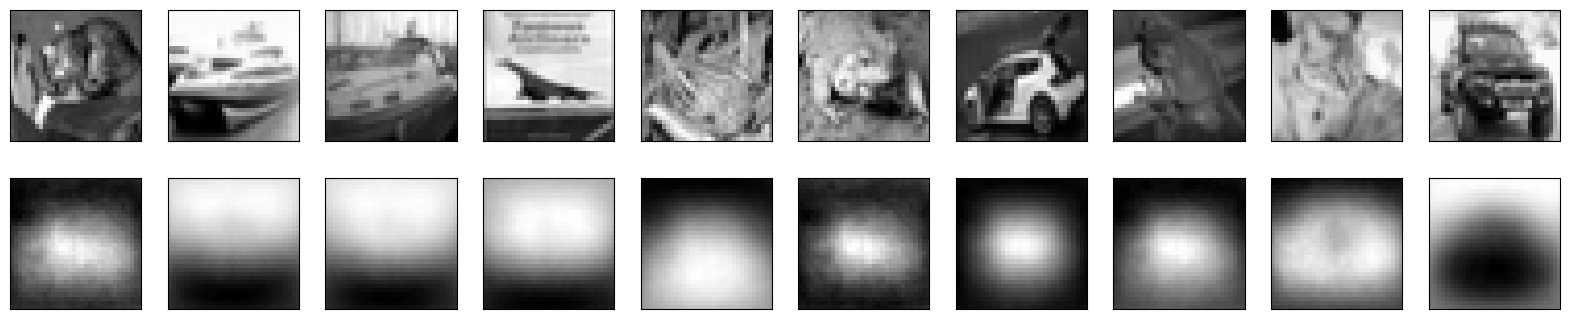

In [25]:
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

# Plot original and reconstructed images
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_gray[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs_1[i].reshape(32, 32), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

The reconstruction error for the autoencoder with three hidden layers, where hidden nodes are approximately evenly distributed among the layers and using sigmoid activation in the encoder and linear activation in the final decoder layer, is quite poor at 0.43.

Theoretically, a 3 hidden layer autoencoder should have performed better than a single hidden layer autoencoder due to its increased capacity to capture complex patterns in the data. However, this is not guaranteed and depends on factors such as the dataset size, the risk of overfitting, and the effectiveness of the training process. Deeper models can better represent intricate structures but in this case are prone to issues like vanishing gradients, which can affect convergence.

Ultimately, while a more complex model has the potential for lower reconstruction error, in our case the simpler models outperforms the new model much better.
